# Interactive Dynesty Demo

This is a simple interactive demo that briefly goes over nested sampling and some of the features available in `dynesty`. This is meant to be a living document that will eventually get turned into documentation at some point in the future.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

# Overview

In standard Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

**Nested sampling** [(Skilling 2006)](https://projecteuclid.org/euclid.ba/1340370944) attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within an **iso-likelihood contour** set by $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. 

More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $1 > X_0 > X_1 > \dots > X_i > \dots > X_N > 0$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## How Nested Sampling Works

### Basic Algorithm

We start with a number of $K$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we remove the live point with the lowest likelihood $\mathcal{L}_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_i$. 

### Evidence Estimation

It can be shown through some neat statistical arguments (which are outlined in more detail below) that this sampling procedure actually allows us to approximate the prior volume of the previous live point (a **"dead" point**) based on the current iteration as

$$ \ln X_i \approx -\left(i \pm \sqrt{i}\right)/K \quad .$$

This enables us to directly estimate the evidence (and errors) using a set of $N$ dead points via

$$ \mathcal{Z} = \int_{0}^{1} \mathcal{L}(X) \, dX \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \, f(\mathcal{L}_i) \, w_i $$

where $w_i \equiv \Delta X_i$ is the associated weight. As an example, for a simple linear integration scheme using rectangles, we can take $f(\mathcal{L}_i) = \mathcal{L}_i$ and $w_i = X_{i-1} - X_i$. If we want to use a quadratic integration scheme with trapezoids (used by `dynesty`), we instead can take $f(\mathcal{L}_i) = (\mathcal{L}_{i-1} + \mathcal{L}_i) / 2$.

### Posterior Estimation

We can subsequently estimate posteriors "for free" from the same $N$ dead points used to compute the evidence by assigning each sample its associated **importance weight**

$$ P(\boldsymbol{\Theta}_i) \equiv p_i \approx \hat{p}_i = \frac{\mathcal{L}_i w_i}{\sum_{i=1}^{N} \mathcal{L}_i w_i} = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}} \propto \mathcal{L}_i w_i \quad . $$

### Stopping Criteria

The remaining prior volume $\Delta \mathcal{Z}_i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multipled by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This essentially assumes that the remaining prior volume interior to the last dead point is a uniform slab with likelihood $\mathcal{L}_{\max}$. In general, this error estimate often serves as a reasonable threshold that can be used for deciding when to stop sampling from an arbitrary distribution when deriving the evidence. Other stopping criteria are discussed later.

### Challenges

The main theoretical requirement for nested sampling are:
1. that samples are drawn sequentially subject to the hard likelihood constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_{i}$, and
2. that all samples used to compute/replace live points are **independent and identically distributed (i.i.d.)** random variables drawn from the prior.

The first requirement is entirely algorithmic and easy to satisfy. The second, however, is much more difficult to satisfy if we want to sample the likelihood efficiently. In other words, while it is straightforward to generate samples from the prior, by design nested sampling makes this simple sampling scheme increasingly more inefficient as time goes on.

Solutions to this problem involve some combination of:
- proposing new live points by evolving one or more current live points to new (independent) positions within the likelihood constraint and
- approximately bounding the iso-likelihood contours so avoid sampling from regions associated with larger prior volumes.

In both cases, it is much easier to deal with uniform priors. As a result, most nested sampling algorithms/packages (including `dynesty`) sample over the $n$-dimensional unit cube, transforming samples back to the original parameter space on the fly. Accomplishing this requires an appropriate **prior transform** (i.e. the inverse CDF).

# Demonstration on 3-D Correlated Multivariate Normal

Let's get a sense for how `dynesty` works using a strongly correlated 3-D **multivariate Normal** distribution.

In [3]:
import dynesty

In [4]:
# 3-D correlated multivariate normal likelihood
ndim = 3
C = np.eye(ndim)
C[C==0] = 0.95
Cinv = linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))

def loglikelihood(x):
    """Defines the (unnormalized) log-likelihood."""
    return -0.5 * np.dot(x.T, np.dot(Cinv, x)) + lnorm

As described above, `dynesty` samples over the unit cube. We now define the transformation that takes our uniform samples and transforms them back to the variables of interest.

In [5]:
# prior transform
def prior_transform(u):
    """Defines a flat prior between -10. and 10. in all dimensions."""
    return 10. * (2. * u - 1.)

## Sampling the Target Distribution

### Bounding Options

`dynesty` supports a number of methods for bounding the target distribution:
- **no bound** (`'none'`), i.e. sampling from the entire unit cube,
- a **single bounding ellipsoid** (`'single'`),
- **multiple bounding ellipsoids** (`'multi'`),
- **overlapping balls** centered on each live point (`'balls'`), and
- **overlapping cubes** centered on each live point (`'cubes'`).

### Sampling Options

`dynesty` also supports several different sampling methods conditioned on those bounds:
- **uniform** sampling (`'unif'`),
- **random walks** away from a current live point (`'rwalk'`),
- **slice sampling** away from a current live point (`'slice'`), and
- **random trajectories** (also known as [reflective slice sampling](https://www.seas.harvard.edu/courses/cs281/papers/neal-2001.pdf) or [Galilean Monte Carlo](https://arxiv.org/abs/1312.5638)) away from a current live point (`'rtraj'`).

### Initializing the Sampler

We will now initialize our sampler. For this demonstration, we'll use multi-ellipsoidal decomposition [(Feroz et al. 2008)](https://arxiv.org/abs/1306.2144) to bound the likelihood distribution as we go using $K=1000$ live points, and propose new live points by sampling uniformly within the set of (overlapping) ellipsoids. These tend to give very efficient proposals in low-to-moderate dimensions ([Handley et al. 2015](https://arxiv.org/abs/1506.00171)), although they have a tendency to over-constrain the remaining prior volume ([Buchner 2014](https://arxiv.org/abs/1407.5459)). By default, `dynesty` uses bootstrapping to mitigate this problem, which works well in general but can significantly slow down new proposal generation when many ellipsoids are used.

In [6]:
# initialize our nested sampler
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                bound='multi', sample='unif', nlive=1000)

### Sampling Internally

We can now begin sampling from our target distribution. Sampling will continue until the specified stopping criteria are reached, which can either be a fixed number of iterations (`maxiter`), a fixed number of likelihood calls (`maxcall`), or specified $\Delta \ln \hat{\mathcal{Z}}_i \equiv \ln \hat{\mathcal{Z}}_{\textrm{est}} - \ln \hat{\mathcal{Z}}_i$ tolerance between the estimated total evidence $\hat{\mathcal{Z}}_{\textrm{est}}$ and the currently computed evidence $\hat{\mathcal{Z}}_i$ (`dlogz`). By default, the "standard" nested samplers in `dynesty` are optimized for evidence estimation, and the stopping criteria default to either $\Delta \ln \hat{\mathcal{Z}}_i < 0.005 (K+1)$ if we want to "recycle" the final remaining set of live points that would otherwise be wasted and $\Delta \ln \hat{\mathcal{Z}}_i < 0.01$ otherwise.

In [7]:
# sample from the target distribution
sampler.run_nested()

# save our results
res = sampler.results

iter: 5634+1000 | nc: 1 | ncall: 12865 | eff(%): 57.143 | logz: -8.936 +/-  0.139 | dlogz:  0.006           


That looks pretty good overall. In particular, our sampling efficiency over the course of our ~7.5k samples is ~60%, significantly higher than other sampling methods such as **Markov Chain Monte Carlo**, especially given that our samples are (in theory) i.i.d. We'll return to this comparison in more detail later.

## Extending a Run

Let's see if we can do any better by adding more samples until an even more stringent stopping criterion is met. By default, `dynesty` keeps track of the live points and final set of samples, making it easy to add additional samples to the same run, as shown below.

In [8]:
sampler.run_nested(dlogz=0.5)

iter: 8568+1000 | nc: 1 | ncall: 6112 | eff(%): 58.759 | logz: -8.884 +/-  0.090 | dlogz:  0.000         


### Sampling Externally

In addition to having our samples generated entirely internally to our `NestedSampler` object via `run_nested()`, `dynesty` can also be run explicitly as a **generator** using the `sample()` option. We demonstrate this feature below, again continuing where we originally left off to add even more samples to our current run.

In [9]:
# continue sampling from where we left off
ncall = sum(res.ncall) - res.nlive
nit = res.niter
for it, results in enumerate(sampler.sample(dlogz=0.01)):
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, 
     logzvar, h, nc, worst_it, propidx, eff, delta_logz) = results
    ncall += nc
    if delta_logz > 1e6:
        delta_logz = np.inf
    if logzvar >= 0.:
        logzerr = np.sqrt(logzvar)
    else:
        logzerr = np.nan
    sys.stderr.write("\riter: {:d} | nc: {:d} | ncall: {:d} | eff(%): {:6.3f} | "
                     "logz: {:6.3f} +/- {:6.3f} | dlogz: {:6.3f} > {:6.3f}      "
                     .format(nit + it, nc, ncall, eff, logz, logzerr, delta_logz, 0.01))

# add the remaining live points back into our final results (they are removed each time by default)
for it2, results in enumerate(sampler.add_live_points()):
    (worst, ustar, vstar, loglstar, logvol, logwt, logz,
     logzvar, h, nc, worst_it, propidx, eff, delta_logz) = results
    ncall += 1
    if delta_logz > 1e6:
        delta_logz = np.inf
    if logzvar >= 0.:
        logzerr = np.sqrt(logzvar)
    else:
        logzerr = np.nan
    sys.stderr.write("\riter: {:d}+{:d} | nc: {:d} | ncall: {:d} | eff(%): {:6.3f} | "
                     "logz: {:6.3f} +/- {:6.3f} | dlogz: {:6.4f}                "
                     .format(nit + it, it2+1, nc, ncall, eff, logz, logzerr, delta_logz))

res2 = sampler.results

iter: 10598+1000 | nc: 1 | ncall: 17966 | eff(%): 59.820 | logz: -8.884 +/-  0.085 | dlogz: 0.0000                

Those results are nearly identical even though we doubled the number of samples. This demonstrates how much we can gain by recycling the final set of live points.

## Results

Now let's see how we did!

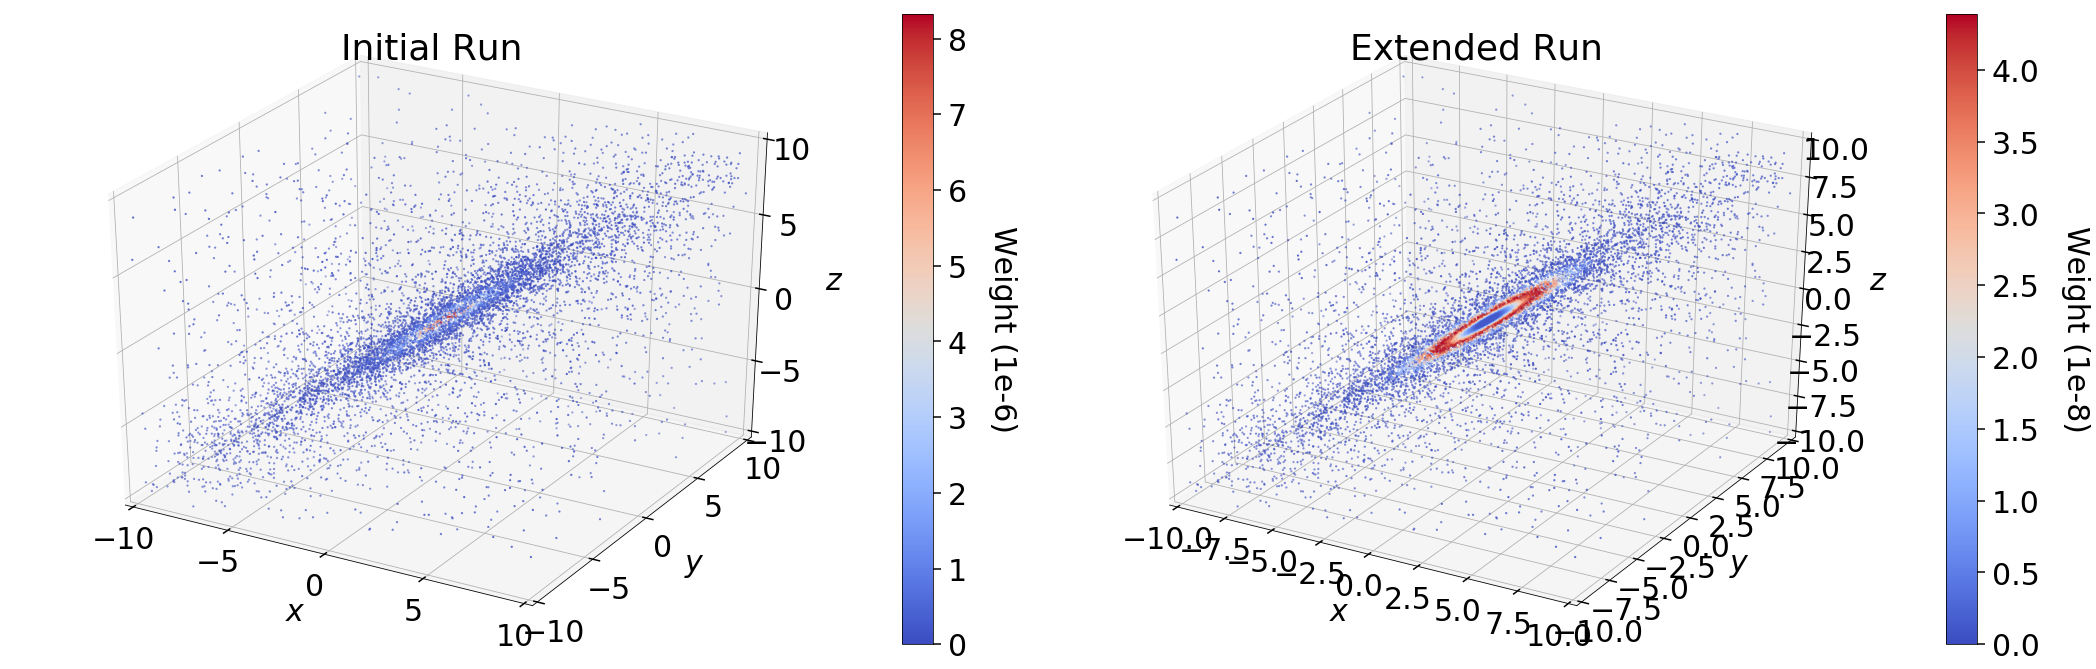

In [10]:
# 3-D plots of position and likelihood, colored by weight
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(121, projection='3d')

# plotting the initial run
p = ax.scatter(res.samples[:, 0], res.samples[:, 1], res.samples[:, 2],
               marker='.', c=np.exp(res.logwt) * 1e7, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xticks(np.linspace(-10., 10., 5))
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_yticks(np.linspace(-10., 10., 5))
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zticks(np.linspace(-10., 10., 5))
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Initial Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-6)', labelpad=50., rotation=270.)
plt.tight_layout()

# plotting the extended run
ax = fig.add_subplot(122, projection='3d')
p = ax.scatter(res2.samples[:, 0], res2.samples[:, 1], res2.samples[:, 2],
               marker='.', c=np.exp(res2.logwt) * 1e8, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Extended Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-8)', labelpad=50., rotation=270.)
plt.tight_layout()

That looks pretty good overall. We see that the majority of the importance weight $\hat{p}_i$ is concentrated in the center in the initial run, but around the outer portions of the Gaussian in the extended run. This represents a compromise between the likelihood $\mathcal{L}_i$ and the change in prior volume $w_i = \Delta X_i$. This difference in behavior is because the prior volume spanned by point with the $k$th largest likelihood out of the final set of $K$ live points follows

$$ X_{N+k} \approx X_{N+k-1} \times k / (K+1) $$

since they are uniformly sampled within $X_{N}$. In the case where there is a significant portion of prior volume remaining (as in our initial run), this can lead to extremely rapid traversal of the remaining prior volume and hence large volume weights $w_i = \Delta X_i$ whose impact dominates over the likelihood $\mathcal{L}_i$ of the samples. This will be highlighted in more detail below.

# Visualizing Outputs

Let's take a more detailed look at what our nested sampler is doing over the course of our run. `dynesty` has several built-in plotting utilities to help visualize outputs within the `plotting` module.

In [11]:
from dynesty import plotting as dyplot

## Prior Volume Compression

One of the most direct ways of visualizing how nested sampling computes the evidence is by examining the relationship between the prior volume $\ln X_i$ and:
1. the (effective) iteration $i$, which illustrates how quickly/slowly our samples are compressing the prior volume,
2. likelihood $\mathcal{L}_i$, to see how smoothly we sample "up" the likelihood curve,
3. importance weight $\hat{p}_i$, showcasing where the bulk of the **posterior mass** is located, and 
4. evidence $\hat{\mathcal{Z}}_i$, to see at what point most of the evidence is coming from.

This can be plotted using `runplot`.

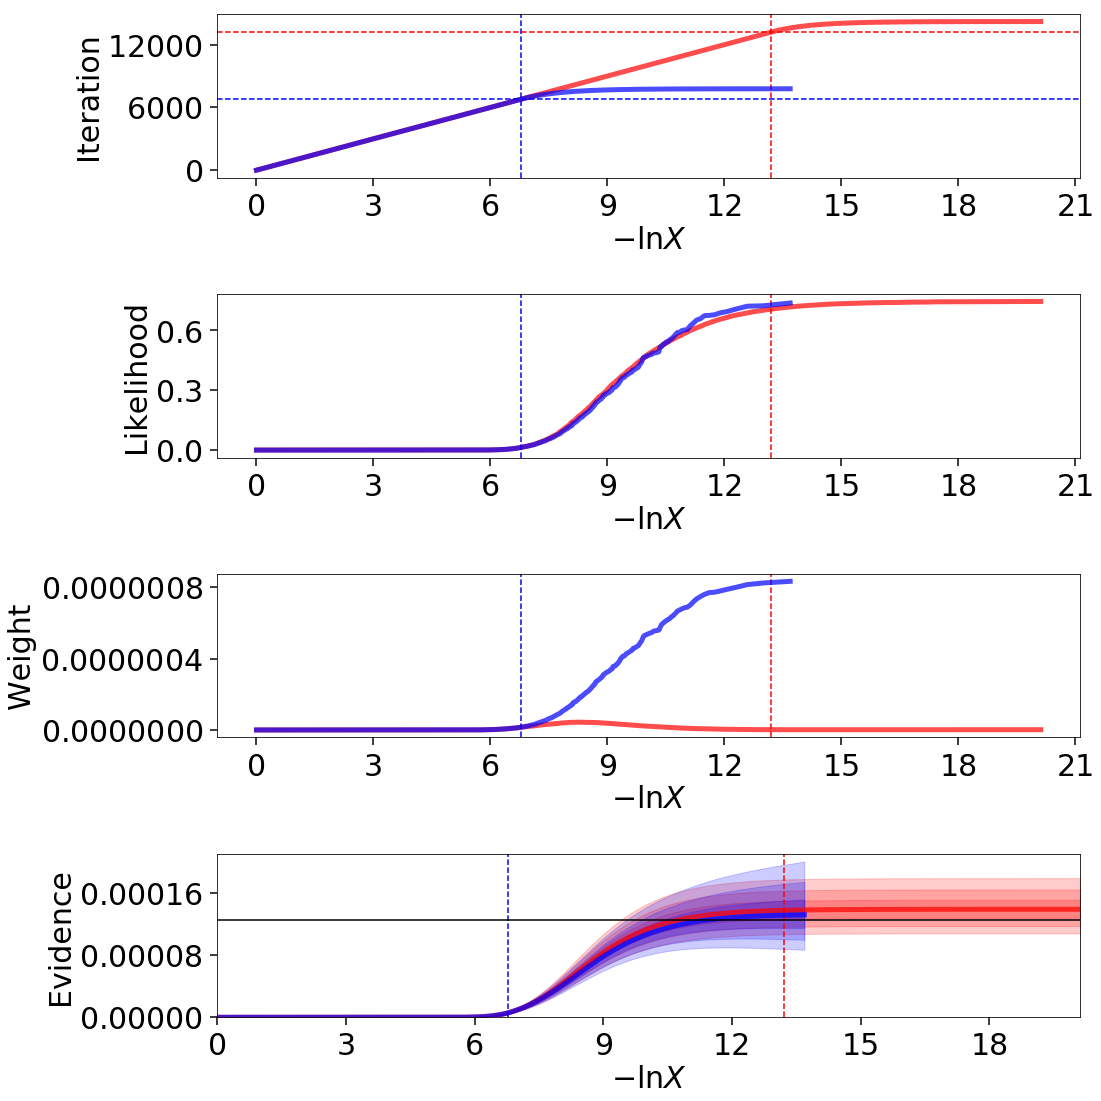

In [12]:
# analytic evidence
lnz_truth = ndim * -np.log(20.)  # log(volume) of prior

# plot extended run
fig, axes = dyplot.runplot(res2, color='red')

# overplot original run
fig, axes = dyplot.runplot(res, color='blue', lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

We see that up until we recycle our final set of live points (indicated by the dashed lines), the relationship between $\ln X_i$ and $i$ is linear. Afterwards, however, it becomes (essentially) logarithmic, rapidly traversing the remaining prior volume. While this clearly introduces additional sampling noise, visible in $\mathcal{L}_i$, $\hat{p}_i$, and the errors on $\hat{\mathcal{Z}}$, the overall effect on $\hat{\mathcal{Z}}$ itself is quite muted (especially given the estimated uncertainties).

## Traces and Posteriors

A standard way for visualizing how our sampler is doing is by taking a look at the **traces** of individual  particles (i.e. "dead points") to see what path they are taking through the distribution as well as the 1-D **marginalized posteriors** to see how well constrained our results ultimately are (especially given the heavily skewed set of weights often provided by nested sampling, as shown above). 

This can be done using `traceplot`. By default, it returns the samples color-coded by their relative weight and the 1-D marginalized posteriors smoothed by a Gaussian kernel with a standard deviation set to ~2% of the provided range (which defaults to the 5-sigma bounds computed from the set of weighted samples).

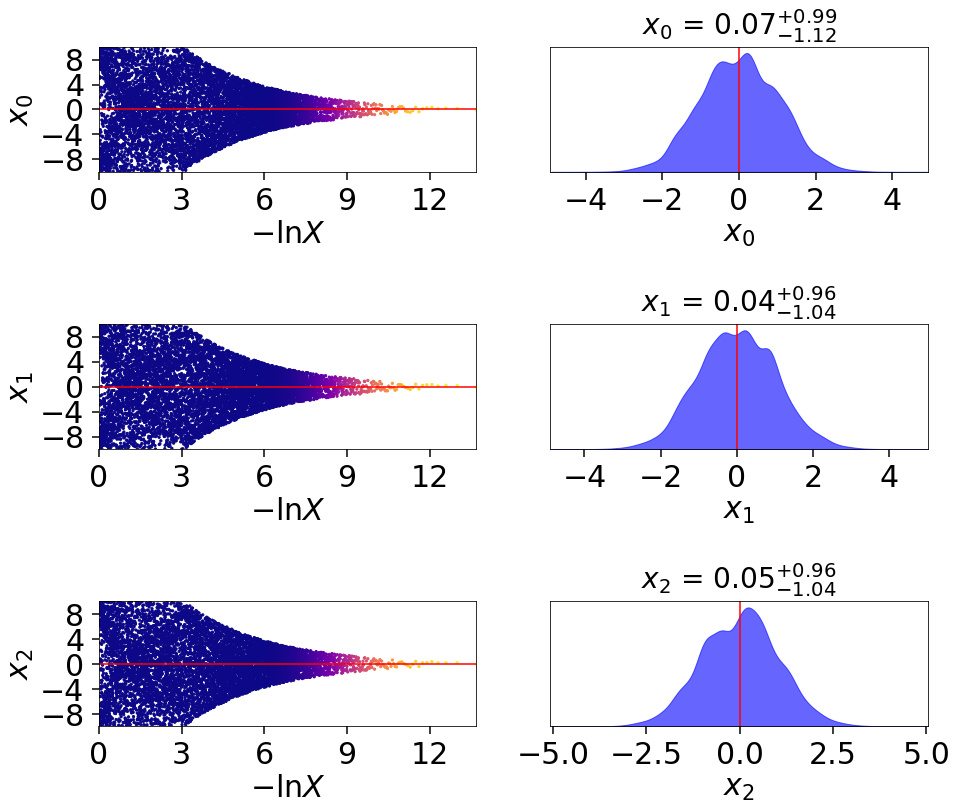

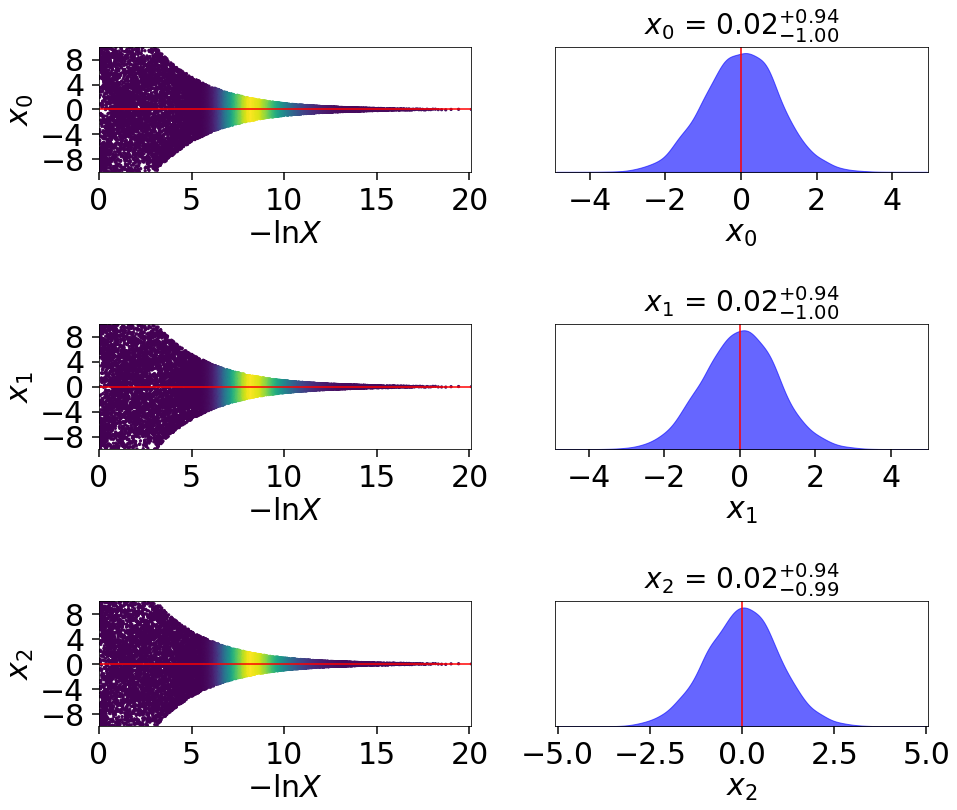

In [13]:
# plotting the original run
fig, axes = dyplot.traceplot(res, truths=[0., 0., 0.], show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[0., 0., 0.], show_titles=True, trace_cmap='viridis',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

We see that although the evidence we estimate is almost identical, the posteriors we derive in our continued run improve considerably since we have more finely sampled the bulk of the posterior mass.

## Corner Plots

In addition to trace plots, one other common way to visualize (weighted) samples is using **corner plots** (also called triangle plots), which show a combination of 1 and 2-D marginalized posteriors. `dynesty` supports several corner plotting functions (based on the excellent `corner` [package](http://corner.readthedocs.io/en/latest/) by Daniel Foreman-Mackey.)

Let's first take a look at the positions and weights of our individual samples to see where our samples are concentrated using `cornerpoints`.

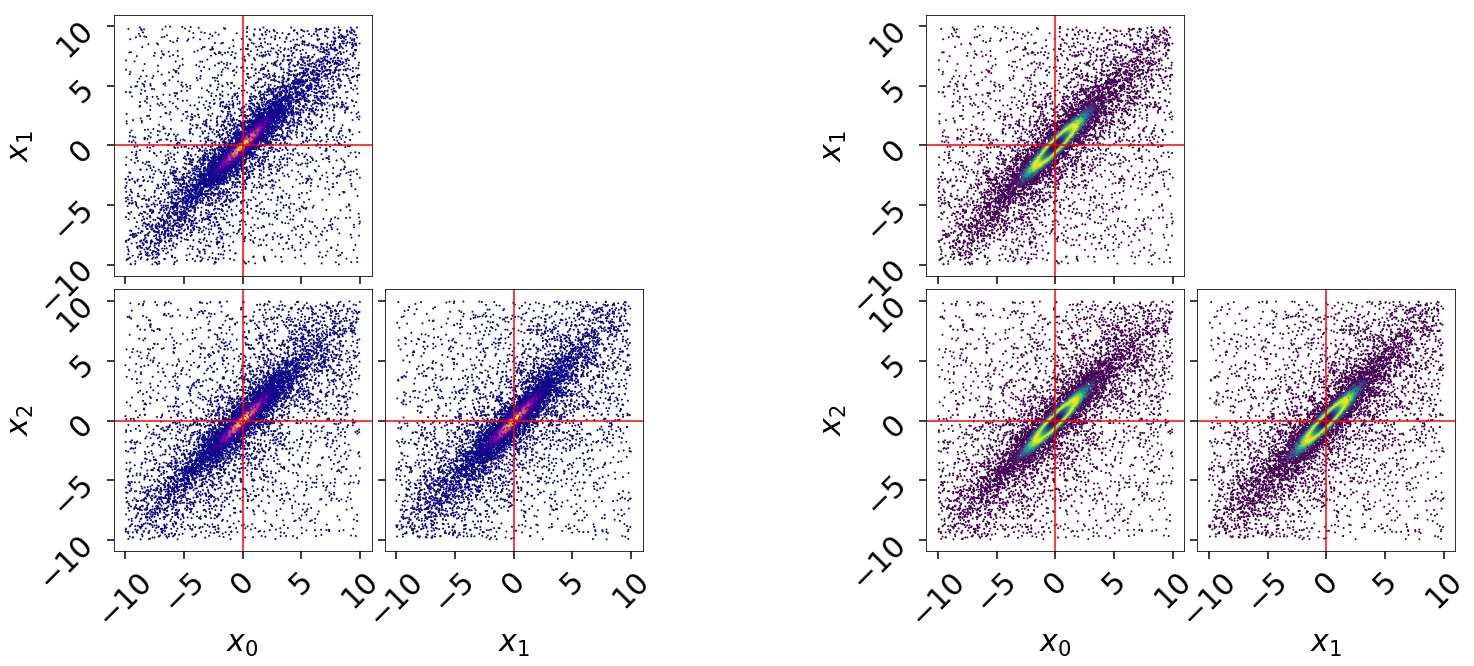

In [14]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=[0., 0., 0.],
                             fig=(fig, axes[:, :2]))

# plot extended run (right)
fg, ax = dyplot.cornerpoints(res2, cmap='viridis', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 3:]))

Just by looking at our projected samples, it is readily apparent that our extended run does a much better job of localizing the overall distribution. Let's try and get a better qualatative handle on this below by plotting the marginal 1-D and 2-D posteriors using `cornerplot`. (Like `runplot`, our distributions are by default smoothed by 2% in the specified range using a Gaussian (Normal) kernel).

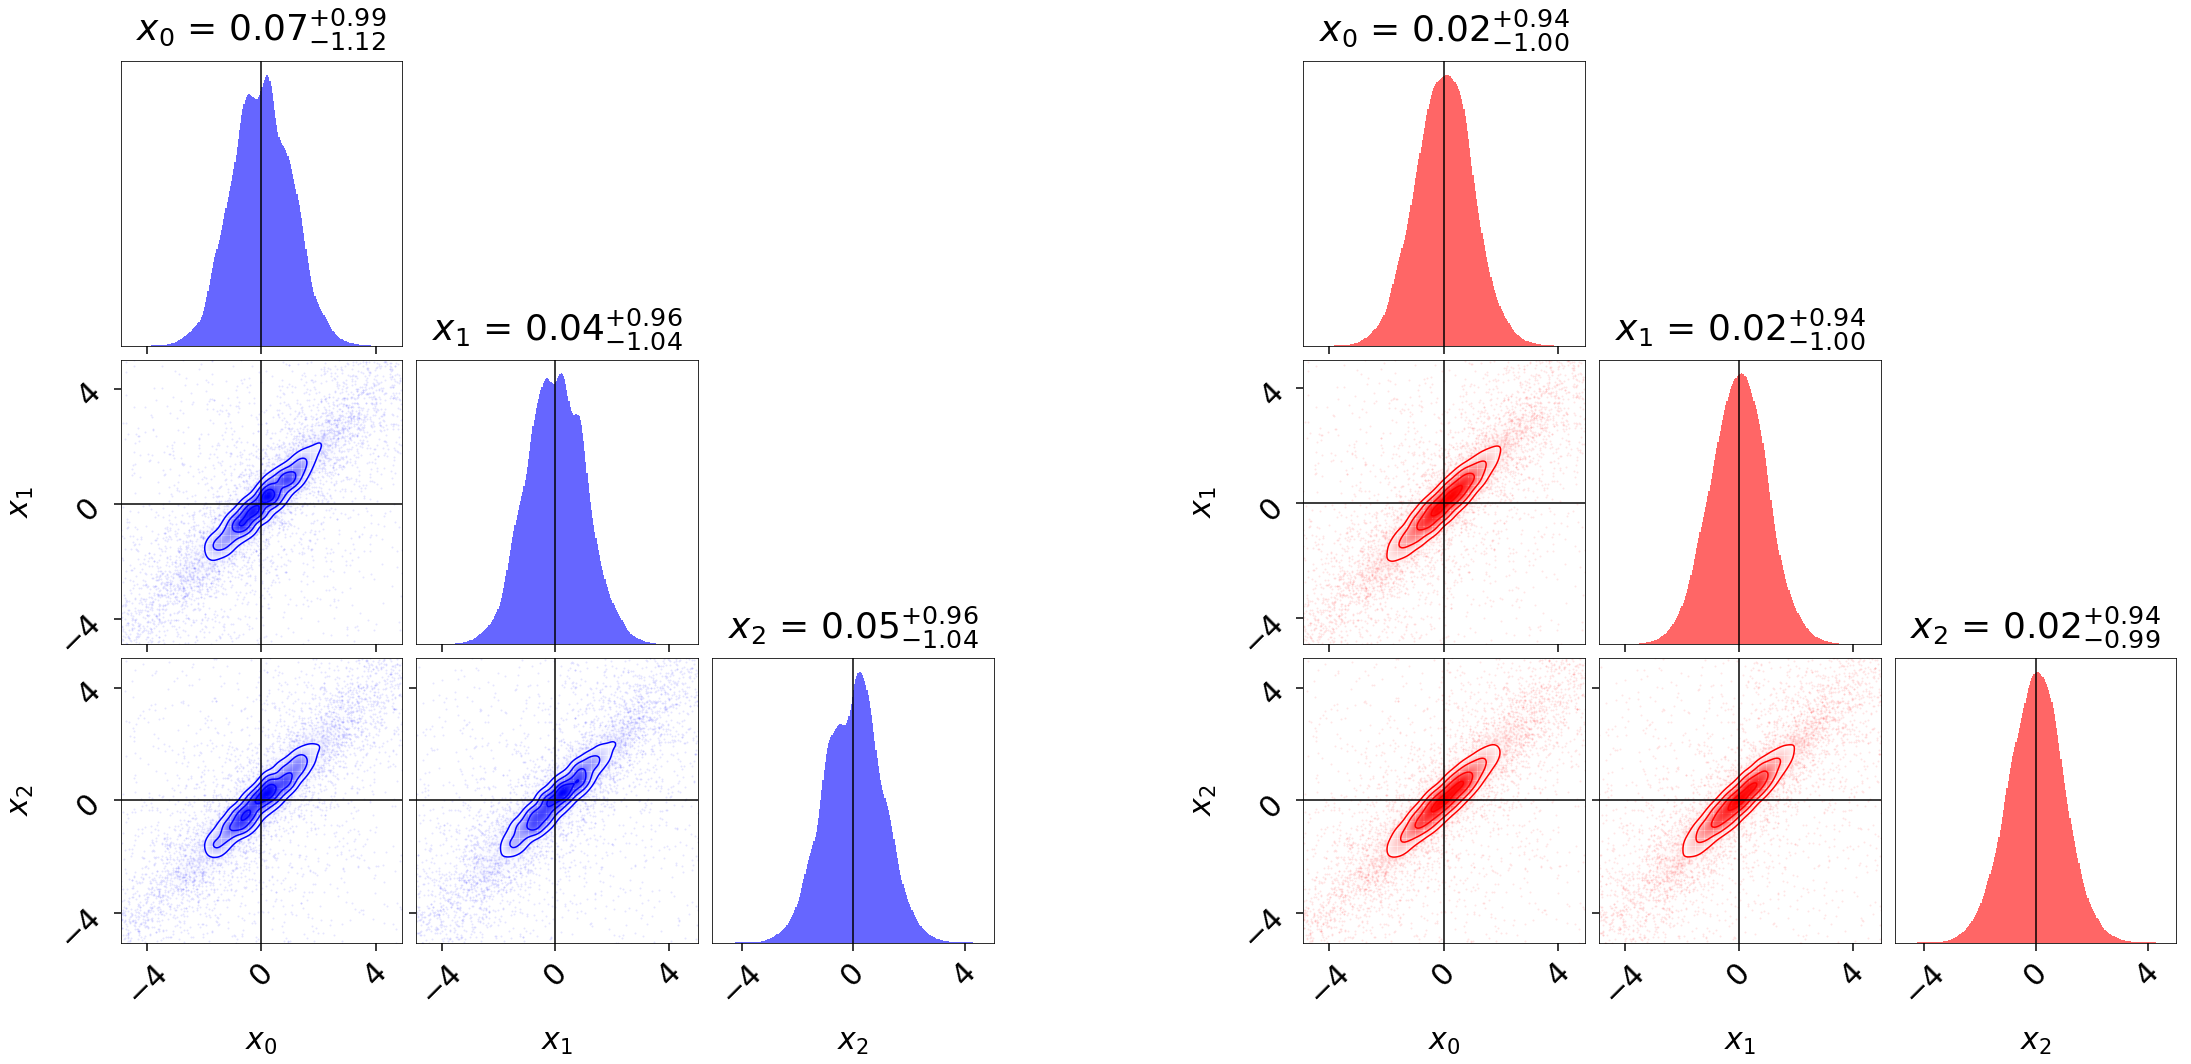

In [15]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

Our original distribution appears to give significantly "noisier" estimates of the posterior than our extended run, although both don't appear as "smooth" as many distributions samples with MCMC. We'll quantify this more later.

## Evolving Proposals

To visualize how we're sampling in nested "shells", we can look at the evolution of our proposal in a given 2-D projection over the course of the run. The `proposal` function allows us to look at the proposal distributions from two different perspectives: the proposal distribution used to propose new live points at a specific iteration (specified using `it`), or the proposal distribution a given dead point originated from (specified using `idx`). While `proposal` natively plots in the space of the unit cube, if a specified prior transform function is passed all samples are instead converted to the original (native) model space.

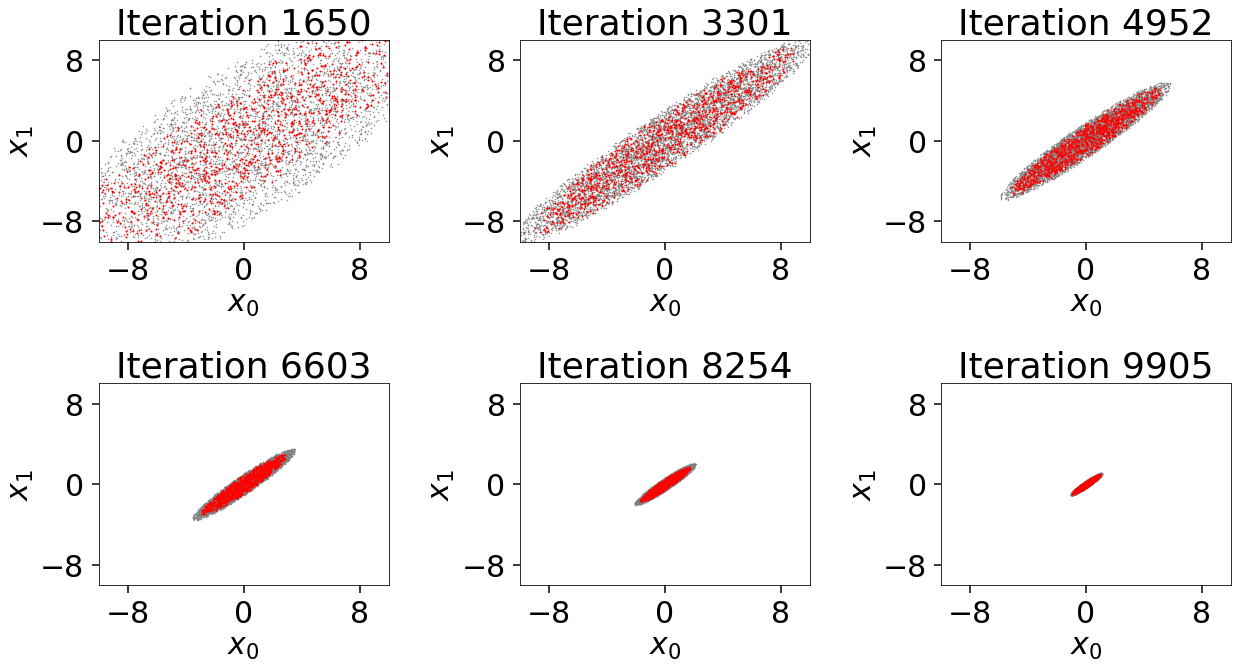

In [16]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*res2.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.proposal(res2, dims=(0, 1), it=it, prior_transform=prior_transform, max_n_ticks=3,
                           show_live=True, fig=(fig, a))
    a.set_title('Iteration {0}'.format(it))
    a.set_xlim([-10., 10.])
    a.set_ylim([-10., 10.])
fig.tight_layout()

Alternately, `cornerprop` generates corner plots for our proposals.

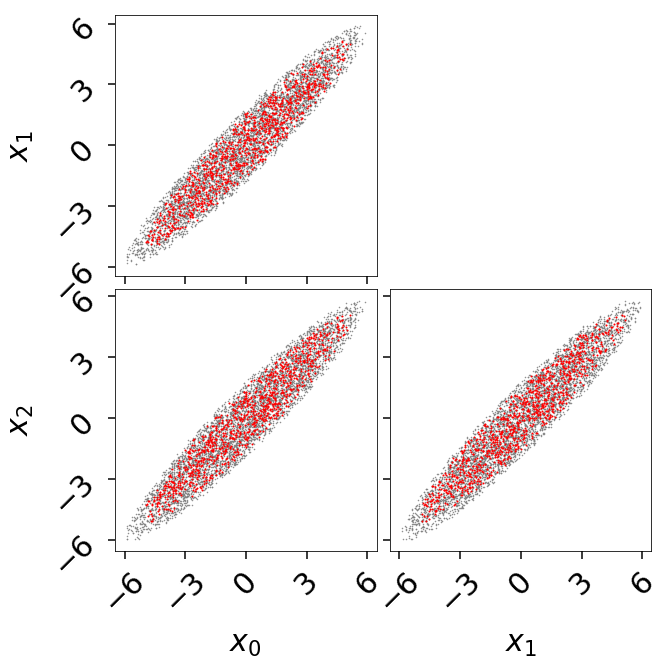

In [17]:
# initialize figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# plot proposals in corner format
fg, ax = dyplot.cornerprop(res2, it=5000, prior_transform=prior_transform, show_live=True, fig=(fig, axes))

We see that our multi-ellipsoid proposals are able to adapt well to the shells over time, ensuring we continue to make efficient proposals without violating our uniform sampling assumptions. We can also see the impact our bootstrapping procedure has on the bounding ellipsoids: they always remain slightly larger than the set of live points. While this slightly decreases our efficiency, it helps ensure we do not "leave out" any likelihood during the course of the run. 

# Sampling Posteriors with Dynamic Nested Sampling

## Motivation

In nested sampling, the number of live points can be both a blessing and a curse. Since prior volume evolves as

$$ \ln X_i \approx - \sum_{j=1}^{i} 1/K = -i /K \quad ,$$

increasing the number of live points ensures we compress the prior volume more slowly. This increases our runtime (scaling as $K$) but ensures a finer approximation of the evidence and posterior. In addition, more live points also enable us to construct more accurate bounding proposal distributions, such as with the multi-ellipsoid decomposition used above.

One immediate drawback, however, is that we compress linearly in $\ln X_i$ at all times, regardless of where the majority of posterior mass is located. This can lead to many wasted samples depending on what quantity we're interesting in accurately estimating (the posterior distributions, evidence, moments, some combination of all of the above, or some function that depends on any of the previously mentioned quantities). Instead, we would like to allocate live points *dynamically* such that our prior volume instead goes as

$$ \ln X_i \approx - \sum_{j=1}^{i} 1/K_j $$

where the number of live points $K_j$ is now variable.

## Adding Samples

While dynamic sampling is powerful, it also involves introducing two more sets of (hyper-)parameters related to the more flexible nature of the technique. The first set is associated with a **weight function**, which takes the current set of dead points and decided where we wish to allocate additional samples. The default weight function used in `dynesty` is

$$ I_i(f_p) = f_p I^p_i + (1-f_p) I^{\mathcal{Z}}(i)_i $$

where $f_p$ is the relative fractional importance we place on posterior estimation, $I_i^p = \hat{p}_i / \sum_j \hat{p}_j$ is the normalized posterior importance weight, and $I^{\mathcal{Z}}_i = (1 - \hat{\mathcal{Z}}_i / \hat{\mathcal{Z}}_{\textrm{est}}) / K_i$ is the normalized evidence weight where $\hat{\mathcal{Z}}_{\textrm{est}}$ is again the estimated total evidence (i.e. including the remainder) and $K_i$ is the number of live points at (effective) iteration $i$. The likelihood ranges where we will add new dead points is then specified by taking the maximum/minimum iteration $i_\min$ and $i_\max$ that satisfies $I_i(f_p) \geq f_{\max} \max(\lbrace \dots, I_i(f_p), \dots \rbrace)$ with some additional left/right padding of $\pm n_{\textrm{pad}}$ indices (where $i_\min \leq 0$ defaults to $0$ and $i_\max > N$ defaults to $N$). By default, these values are set to $f_p=0.8$, $f_\max = 0.8$, and $n_{\textrm{pad}} = 1$.

## Stopping Criteria

The second set of hyper-parameters is associated with a **stopping criterion**, which takes the current set of dead points and decides when we should stop sampling. The default posterior stopping criteria (**NOT IMPLEMENTED YET**) uses the KL divergence between the full set of dead points and resampled/simulated sets of dead points. This is defined as

$$ D_{p^\prime || p} = \int_{\Omega_{\boldsymbol{\Theta}}} P^\prime(\boldsymbol{\Theta}) \ln \left(\frac{P^\prime(\boldsymbol{\Theta})}{P(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} 
\approx \sum_i \hat{p}^\prime_i \ln \hat{p}^\prime_i - \sum_i \hat{p}^\prime_i \ln \hat{p}_i $$

where the sum over $i$ is taken over all dead points (i.e. samples), $\hat{p}_i$ is the importance weight computed using the entire set of dead points, and $\hat{p}^\prime_i$ is the importance weight computed when simulating uncertainties using both random number draws and bootstrap resampling (see below). Since all samples are defined on the same domain, this discrete sum gives an estimate of the divergence between realizations of the posterior and the estimated (mean) posterior. 

The default evidence stopping criteria uses the simulated $\ln \hat{\mathcal{Z}}$ errors from the same sets of dead points as above until the error $\sigma(\ln \hat{\mathcal{Z}}_N)$ reaches a defined stopping point and the remaining evidence $\Delta \ln \hat{\mathcal{Z}}_N < \sigma(\ln \hat{\mathcal{Z}}_N)$ is smaller than the estimated value.  **There will be some additional hyper-parameters involved.**

By default, the posterior/evidence stopping criterion is weighted by $f_p$ and $1-f_p$, respectively, when deciding when to stop.

## Dynamic Sampling in `dynesty`

Although in theory dynamic sampling can be done by adding one live point at a time, in practice this approach is difficult to implement because the number of points that are "live" can change rapidly as we traverse the prior volume (i.e. as we sample "up" the (log-)likelihood curve). In `dynesty`, we opt to use a perturbative approach, where we insert additional live points in "batches" with some guidance from an original "baseline" run.

Dynamic sampling in `dynesty` is implemented using the `DynamicNestedSampler` class (in contrast to the `NestedSampler` classes used above). Like the `NestedSampler`, our `DynamicNestedSampler` uses a fixed set of bounding and sampling methods and can be initialized using a very similar API. One key difference, however, is that we don't need to declare the (initial) number of live points.

In [18]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=3, 
                                        bound='multi', sample='unif')

Just to keep things simple, we'll limit ourselves to two use cases. In the first, we'll use 100 live points to lay down our "baseline" run defining our initial distribution, and then add 5 batches of 175 live points until the maximum possible number of live points is 1000. This means the best our first run can do is achieve a resolution that our initial nested sampler run maintained throughout its entire run.

As before, we can sample internally using the `run_nested()` function.

In [19]:
# sample dynamically from the target distribution
dsampler.run_nested(ninit=100, nbatch=175, maxbatch=5, wt_kwargs={'pfrac': 0.8})

res3 = dsampler.results

run: 5 | iter: 2717 | nc: 2 | ncall: 8093 | eff(%): 33.162 | loglstar: -4.410 < -0.347 < -3.997 | logz: -8.640 +/-  0.260     


Notice that since we've optimized our dynamic sampler for posterior estimation over evidence estimation (via the default weight function), the errors on our evidence estimates have gotten significantly larger. In addition, although we've made ~3x fewer likelihood calls than our original run, our dynamic nested sampler is somewhat less efficient than our original run (40% vs 60%). This is because the effectiveness of our multi-ellipsoidal proposals depend on the number of live points -- using more live points give more defined and stable ellipsoidal bounds, but leads to slower prior volume compression.

For our second case, let's now continue adding in batches until our dynamic nested sampler has made around the same number of likelihood calls as our original sampler. We can do this internally using the `add_batch()` function.

In [20]:
# sample until we reach approximately the same number of log-likelihood calls
while dsampler.ncall < sampler.ncall:
    dsampler.add_batch(nbatch=175, wt_kwargs={'pfrac': 0.8})
res4 = dsampler.results

run: 15 | iter: 9168 | nc: 1 | ncall: 23148 | eff(%): 39.602 | loglstar: -2.910 < -0.304 < -0.951 | logz: -8.932 +/-  0.155       

Note that, similar to the `NestedSampler`, our `DynamicNestedSampler` can also add samples externally using generators. The relevant functions to do that are `sample_initial()` and `sample_batch()`, which are wrapped by `add_batch()` and `run_nested()`.

## Visualizing Results

First, let's take a look at how the number of live points changes over the course of our runs.

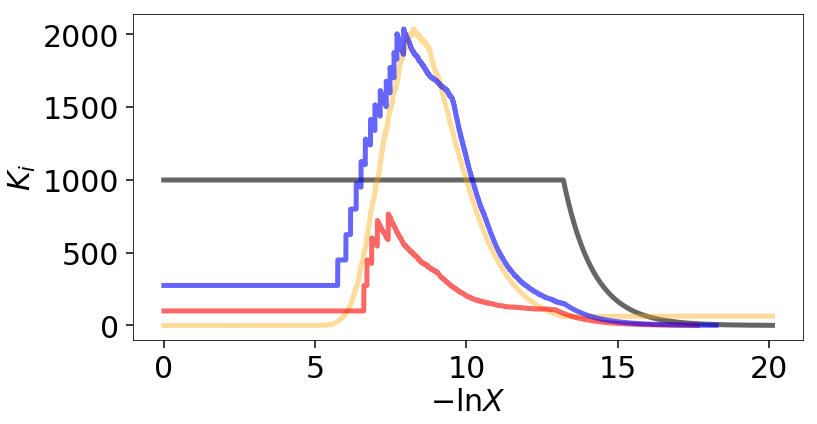

In [21]:
# plot live points as a function of prior volume
plt.figure(figsize=(12,6))
plt.xlabel(r'$-\ln X$')
plt.ylabel(r'$K_i$')

# "vanilla" run
nlive =  np.append(np.ones(res2.niter) * res2.nlive, np.arange(1, res.nlive + 1)[::-1])
plt.plot(-res2.logvol, nlive, lw=5, color='black', alpha=0.6)
plt.plot(-res2.logvol, np.exp(res2.logwt) / max(np.exp(res2.logwt)) * max(res4.samples_n), 
         color='orange', lw=5, alpha=0.4)

# initial dynamic run
plt.plot(-res3.logvol, res3.samples_n, lw=5, color='red', alpha=0.6)

# extended dynamic run
plt.plot(-res4.logvol, res4.samples_n, lw=5, color='blue', alpha=0.6)

We can see that the general shape of the dynamic runs trace the overall shape of the posterior, as desired, but in general is skewed left. This is because the evidence weights are entirely to the left of the majority of the posterior mass, since the more samples we add before hitting the bulk of the posterior enables us to increase our accuracy of $w_i=\Delta X_i$. The weighted average between the evidence and posterior weights tends to skew the distribution left.

We can see the impact our samples have on our inference using the same plotting diagnostics as before.

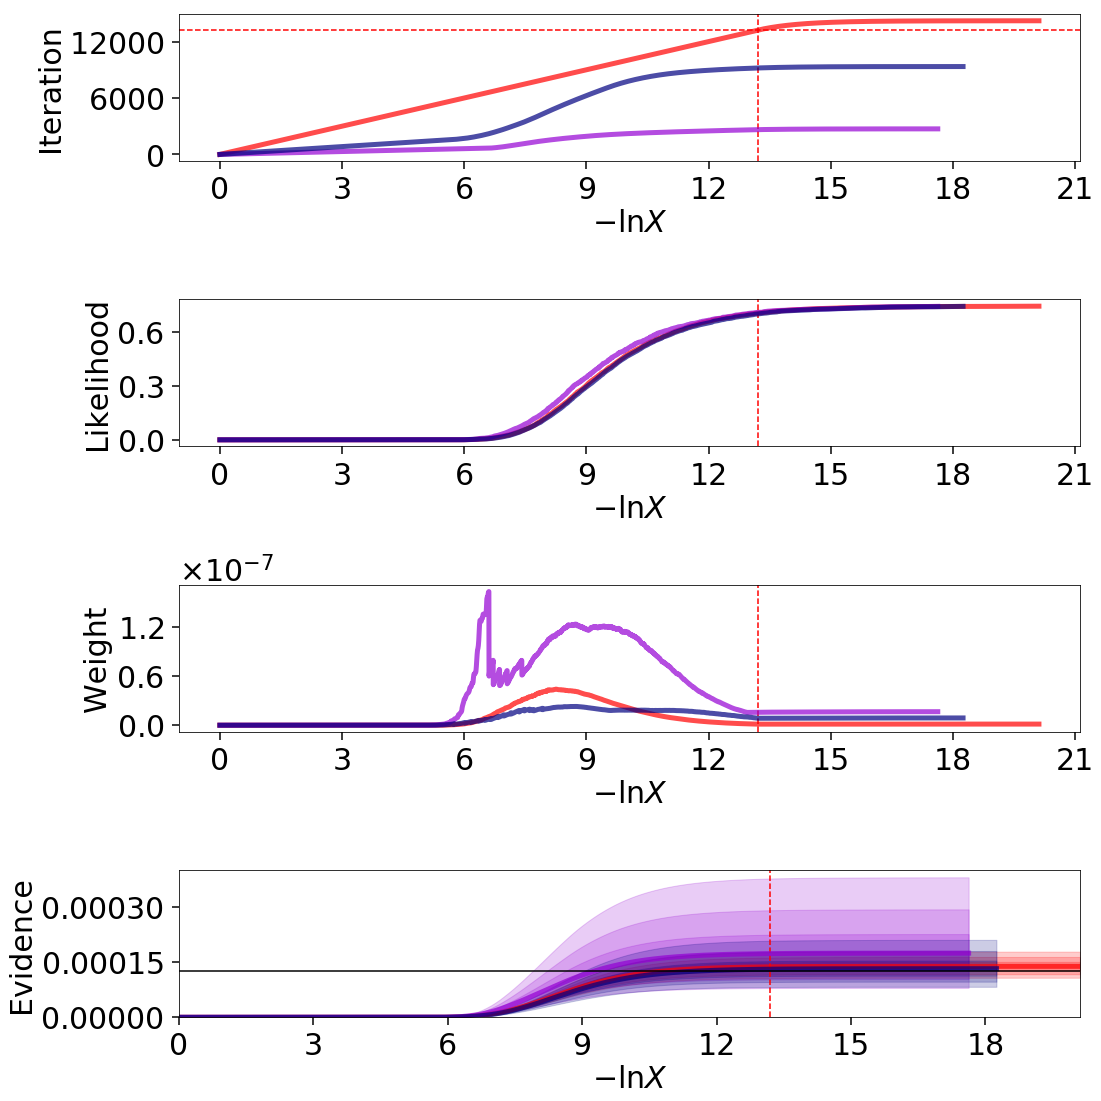

In [22]:
# plot extended run with fixed number of live points
fig, axes = dyplot.runplot(res2, color='red')

# overplot dynamic run
fig, axes = dyplot.runplot(res3, color='darkviolet', fig=(fig, axes))

# overplot extended dynamic run
fig, axes = dyplot.runplot(res4, color='navy', lnz_truth=lnz_truth, truth_color='black', 
                           fig=(fig, axes))

fig.tight_layout()

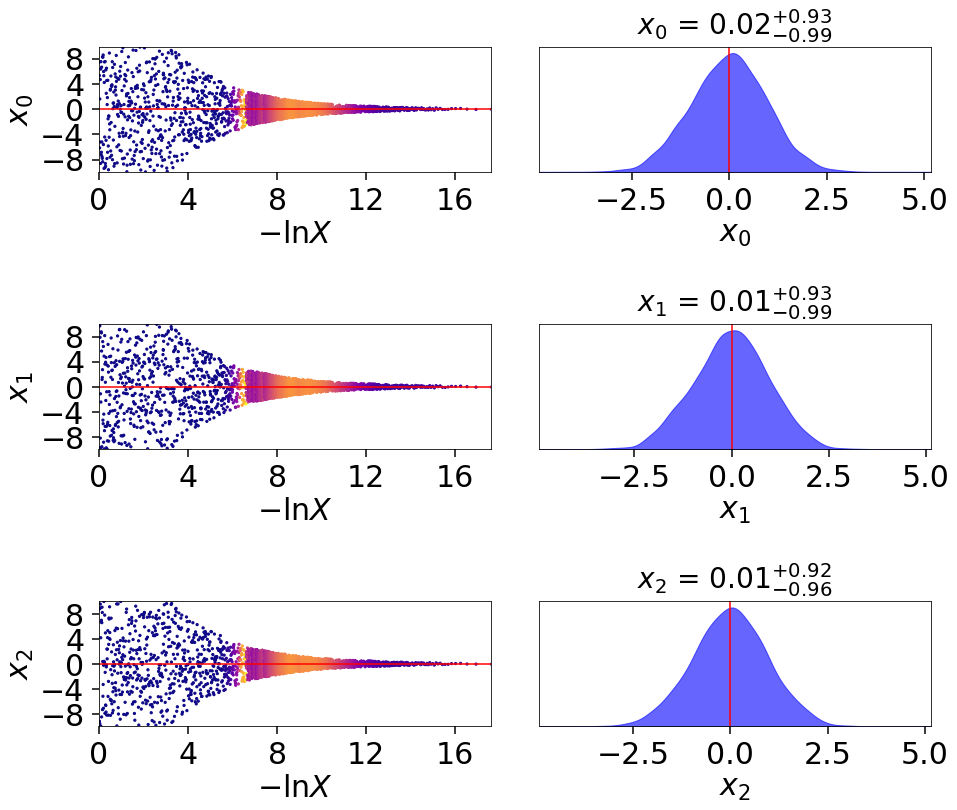

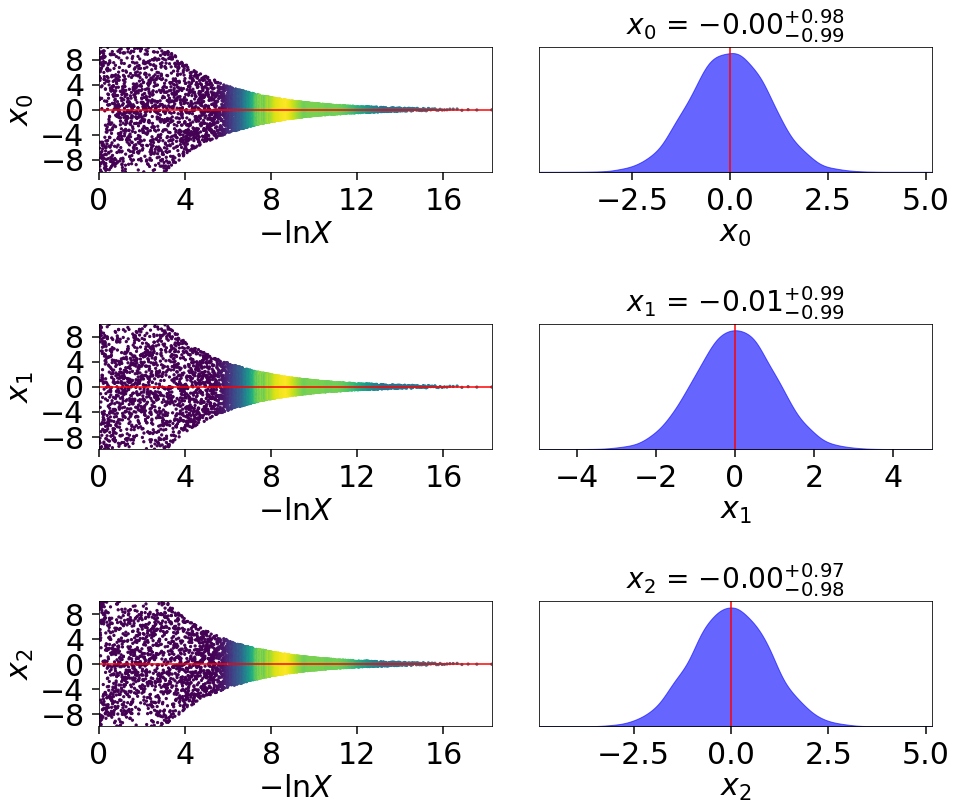

In [23]:
# plotting the dynamic run
fig, axes = dyplot.traceplot(res3, truths=[0., 0., 0.], show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

# plotting the extended dynamic run
fig, axes = dyplot.traceplot(res4, truths=[0., 0., 0.], show_titles=True, trace_cmap='viridis',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

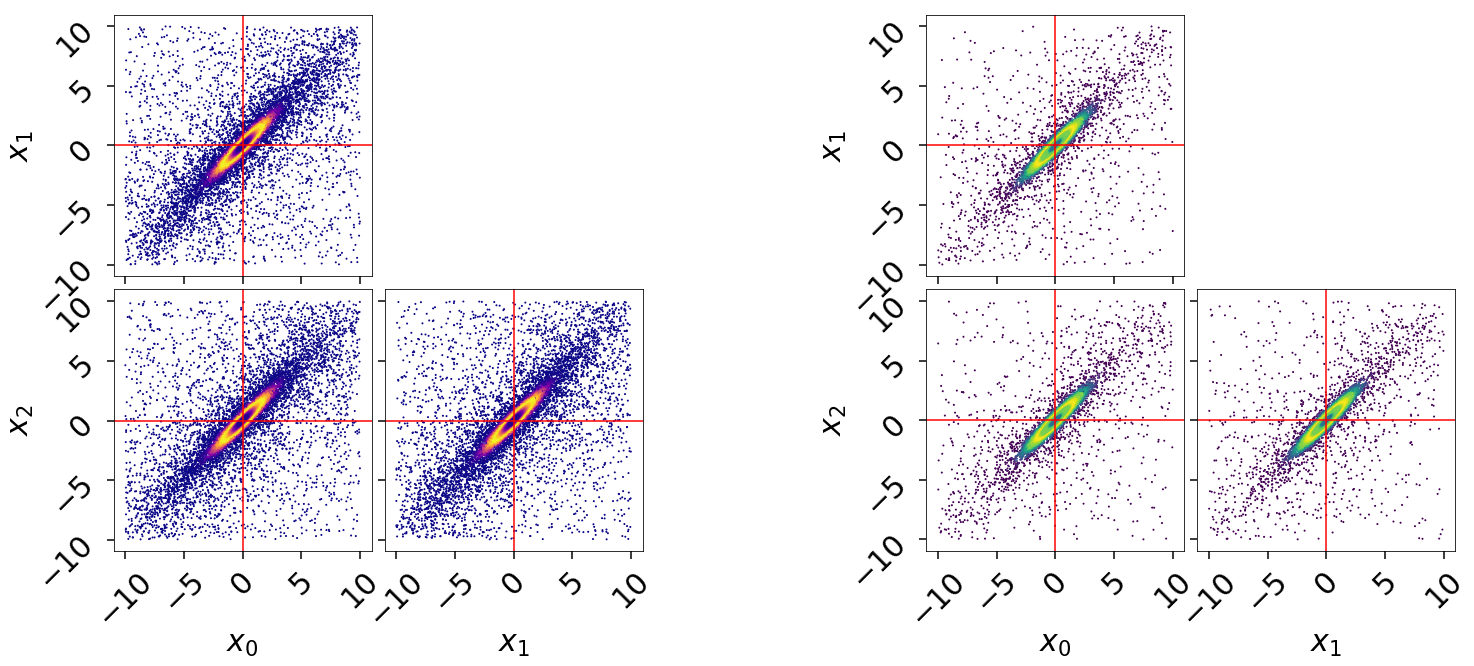

In [24]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (left)
fg, ax = dyplot.cornerpoints(res2, cmap='plasma', truths=[0., 0., 0.],
                             fig=(fig, axes[:, :2]))

# plot extended run (right)
fg, ax = dyplot.cornerpoints(res4, cmap='viridis', truths=[0., 0., 0.],
                             fig=(fig, axes[:, 3:]))

We can see that the dynamic sampler is functioning as intended, adding samples preferentially to regions where the posterior density is highly concentrated. Let's take a look at how this impacts the quality of our inferred posterior.

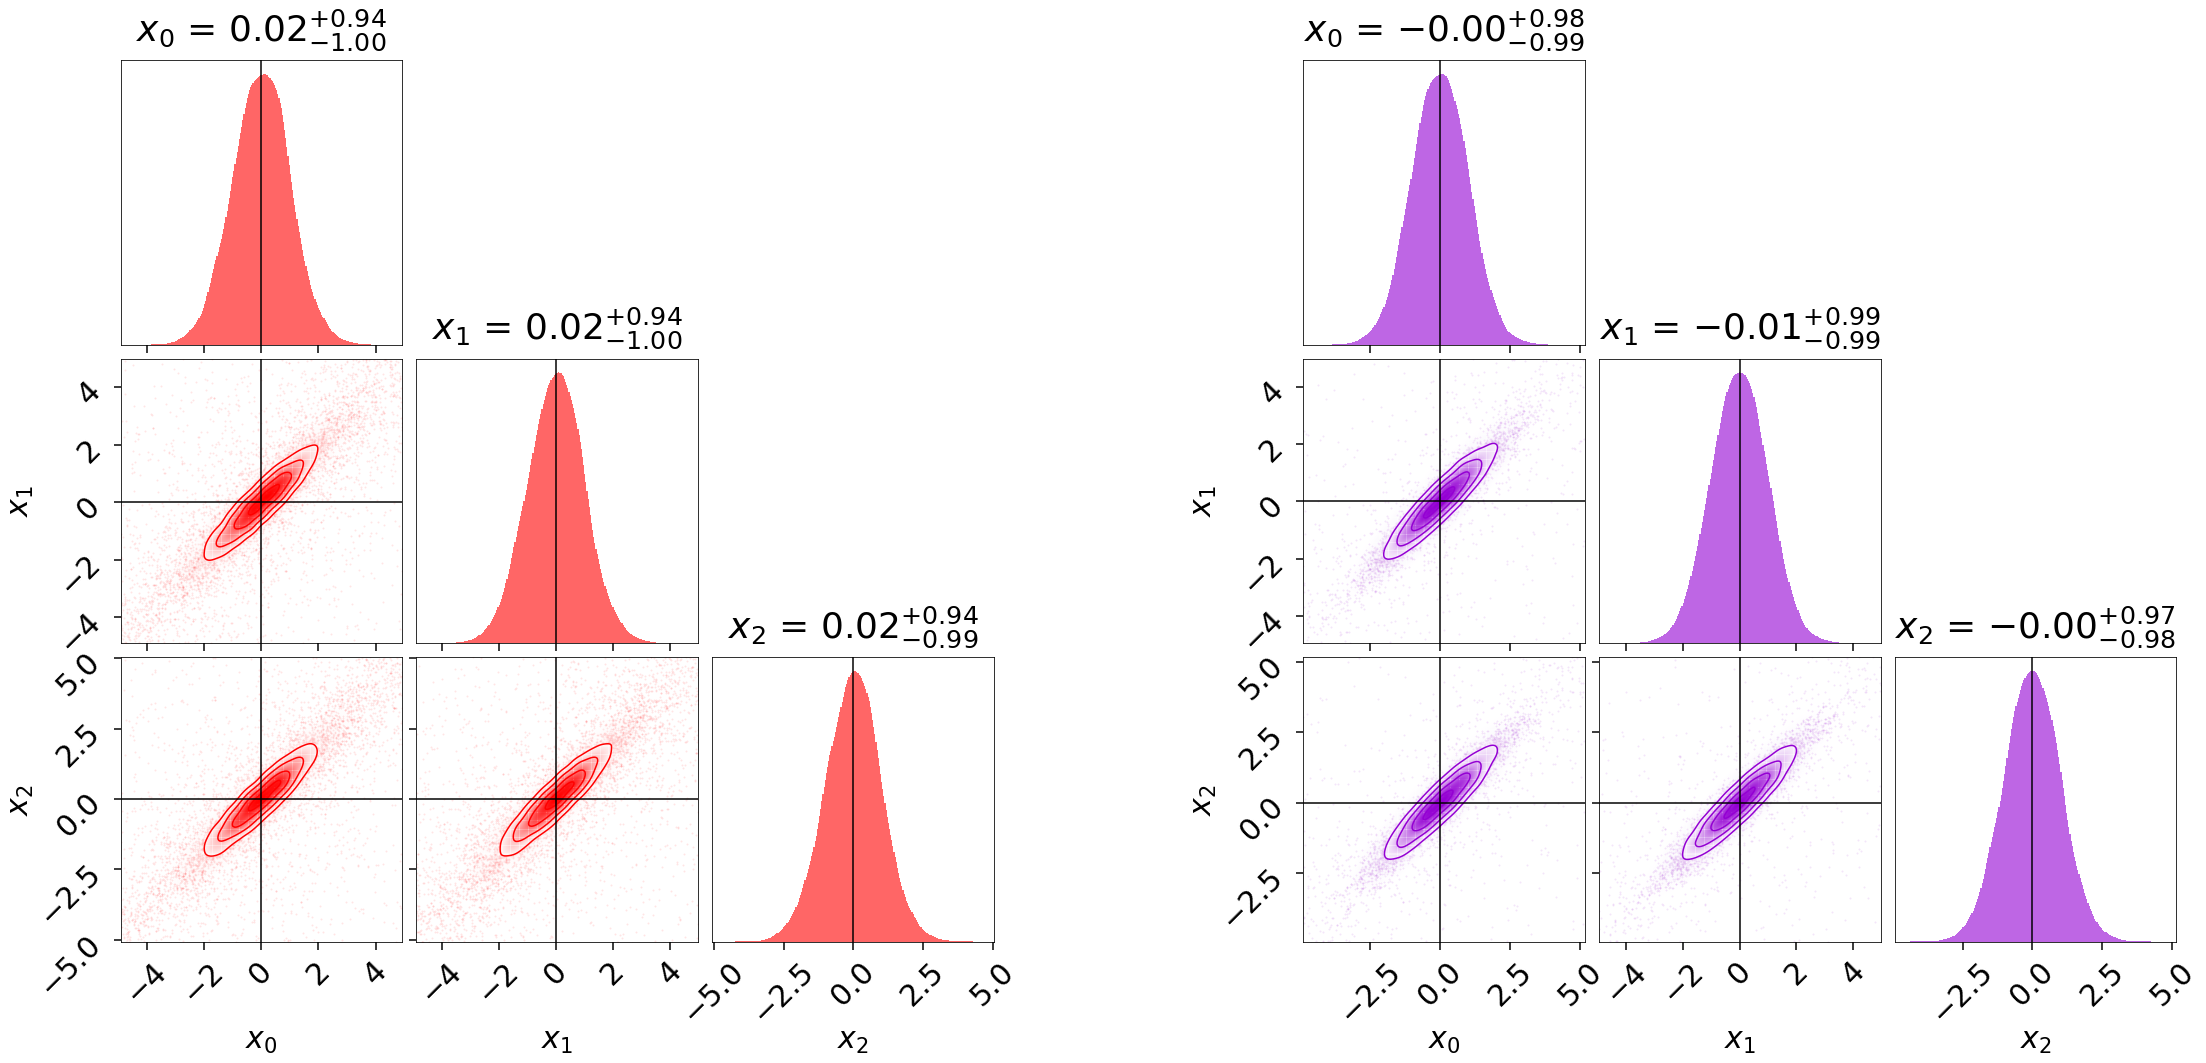

In [25]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res4, color='darkviolet', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, 4:]))

# CODE BEYOND THIS PART IS OUT OF DATE. YOU HAVE BEEN WARNED.

## Dimensional Scaling

Let's see how our performance scales with dimensionality here.

In [ ]:
nlive = 1000

# ndim correlated Gaussians
def run(ndim):
    """Convenience function for running in any dimension"""

    C = eye(ndim)
    C[C==0] = 0.95
    Cinv = inv(C)

    def loglikelihood(x):
        return -0.5*dot(x.T, dot(Cinv, x))
    sys.stdout.write("Ndim={0}...".format(ndim))
    sys.stdout.flush()
    sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                    bound='single', sample='unif', nlive=nlive)
    sampler.run_nested()
    sys.stderr.flush()
    return sampler.results

In [ ]:
dims = array([1, 2, 3, 4, 5, 7, 10]) # dimensions to sample

# analytic log-evidence values
analytic_logz = {}  # to be filled in later

# compute results
from collections import OrderedDict
results = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results[ndim] = run(ndim)
    results[ndim].time = time.time() - t0
sys.stdout.write("\n")

In [ ]:
x = arange(1,100000+1)

plot(log(x), cumsum(1. / x))
plot([0, 15], [0.5,15.5])

In [ ]:
# ndim correlated Gaussians
def run_dynamic(ndim):
    """Convenience function for running in any dimension"""

    C = eye(ndim)
    C[C==0] = 0.95
    Cinv = inv(C)

    def loglikelihood(x):
        return -0.5*dot(x.T, dot(Cinv, x))
    sys.stdout.write("Ndim={0}...".format(ndim))
    sys.stdout.flush()
    sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                           bound='single', sample='unif')
    sampler.run_nested(ninit=200, nbatch=200, maxbatch=5)
    sys.stderr.flush()
    return sampler.results

In [ ]:
# compute results
results_dynamic = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results_dynamic[ndim] = run_dynamic(ndim)
    results_dynamic[ndim].time = time.time() - t0
sys.stdout.write("\n")

Let's take a look at our results.

In [ ]:
sum(results_dynamic[1].ncall)

In [ ]:
#print("D  analytic    logz  logzerr   nlike  eff(%)   time")
#for ndim, res in results.items():
#    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
#          .format(ndim, 0, res.logz[-1], res.logzerr[-1],
#                  sum(res.ncall)-res.nlive, res.eff, res.time))

figure(figsize=(10, 8))
loglog(dims, dims * sum(results[dims[0]].ncall) / dims[0], lw=2, color='blue', ls='--')
loglog(dims, [sum(results[ndim].ncall) for ndim in dims], lw=3, color='blue')
loglog(dims, dims * sum(results_dynamic[dims[0]].ncall) / dims[0], lw=2, color='red', ls='--')
loglog(dims, [sum(results_dynamic[ndim].ncall) for ndim in dims], lw=3, color='red')
xlabel('Ndim')
ylabel('Ncall')
tight_layout()

While our multi-ellipsoid rejection sampler manages to hold its own until at least 10 dimensions, it starts losing out around 20. 

## Parallelization

Although nested sampling is trivially parallelizable (in the sense that we can easily combine multiple runs together), we often would like to speed up a single run using multiple threads. Since the likelihood function is often the computational bottleneck and we often propose a number of points before updating our proposal distributions, we can use a `Pool` to "queue up" points for evaluation. This allows us to farm out the computationally intensive process of proposing new live points while keeping the serial nature of the algorithm intact.

Parallelization works better when the likelihood calls are expensive, making it computationally more expedient to try a bunch of points rather than one at a time. We'll put this in by hand here.

In [ ]:
# log-likelihood function
def loglike(theta, c1, c2):
    time.sleep(1e-3)
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

In [ ]:
# parallelize ndim Gaussian shells
def parallel_run(ndim, nthreads, pool):
    """Convenience function for running in any dimension with multiple threads."""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Nthreads={0}...".format(nthreads))
    sys.stdout.flush()
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, bound='multi', sample='uniform', nlive=nlive,
                                    queue_size=nthreads, pool=pool, **{'bootstrap': 0})
    sampler.run_nested()
    sys.stderr.flush()
    return sampler.results

In [ ]:
threads = array([1, 2, 4])
ndim = 5
npoints = 1000

# compute results
results = OrderedDict()
for nthreads in threads:
    t0 = time.time()
    with concurrent.futures.ThreadPoolExecutor(nthreads) as pool:
        results[nthreads] = parallel_run(ndim, nthreads, pool)
    results[nthreads].time = time.time() - t0
sys.stdout.write("\n")

Let's now see how we're doing.

In [ ]:
print(" D  N  analytic    logz  logzerr   nlike  eff(%)   time")
for nthreads, res in results.items():
    print("{:2d}  {:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, nthreads, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall)-res.nlive, res.eff, res.time))
    
times = array([res.time for nthreads, res in results.items()])
speedup = times[0] / times

figure(figsize=(10,8))
plot([1, max(threads)], [1, max(threads)], color='black', ls='--', lw=3)
plot(threads, speedup, lw=3, alpha=0.7)
xlim([1, max(threads)])
ylim([1, max(threads)])
xlabel('Nthreads')
xticks(threads)
ylabel('Speedup')
tight_layout()

## Deriving Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful uncertainty estimates on our resulting evidence (and posteriors) using a single run. We'll go into some of the details of this below.

### Statistical Uncertainties

Nested sampling works in theory thanks to the magic of **order statistics**. At the start of our run, we sample $K$ points from the prior with likelihoods $\lbrace \mathcal{L}_1,\dots,\mathcal{L}_{K} \rbrace$ and associated prior volumes $ \lbrace X_1,\dots,X_K \rbrace$. We then want to pick the point with the maximum likelihood $\mathcal{L}_{(K)}$ out of the ordered set $\lbrace \mathcal{L}_{(1)},\dots,\mathcal{L}_{(K)} \rbrace$ with corresponding prior volume $X_{(K)}$ out of the ordered set $\lbrace X_{(1)},\dots,X_{(K)} \rbrace$. 

What is this prior volume? Well, all the points were drawn from the prior, so by the **probability integral transform (PIT)** the corresponding prior volumes are uniformly distributed **random variables** such that

$$ X_1,\dots,X_K \stackrel{i.i.d.}{\sim} \textrm{Unif} $$

where $\textrm{Unif}$ is the standard uniform distribution. It can be shown that the set of *ordered* uniformly distributed random variables (here our prior volumes) can be *jointly* represented by $K+1$ exponential random variables

$$ X_{(j)} \sim \frac{Y_1 + \cdots + Y_j}{Y_1 + \cdots + Y_{K+1}} \quad , \quad Y_1,\dots,Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} $$

where $\textrm{Expo}$ is the standard Exponential distribution.

We are interested in the marginal distribution of $X_{(K)}$ associated with $\mathcal{L}_{(K)}$, since that's the prior volume we are first sampling within. This turns out to be

$$ X_{(j=K)} \sim \textrm{Beta}(j,K-j+1) = \textrm{Beta}(K,1) $$

where $\textrm{Beta}(\alpha,\beta)$ is the Beta distribution.

Once we replace a live point with a new live point that satisfies this constraint, we now want to do the same procedure again. Using the same logic as above, we know that our prior volumes must be i.i.d. uniformly distributed *within the previous volume* (since we just replace the worst point with a new independent draw). At a given iteration $i$ where we just replaced point $i-1$ with prior volume $X_{i-1}$, the prior volume associated with a new $X_i$ we're now trying to remove is then

$$ X_i \sim t_i X_{i-1} ~,~ t_i \sim \textrm{Beta}(K,1) \quad \Rightarrow \quad X_i \sim \prod_{j=1}^{i} t_j ~,~ t_1,\dots,t_i \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad \Rightarrow \quad \ln X_i = \sum_{j=1}^{i} \ln t_i \quad . $$

Once the algorithm terminantes after $N$ iterations using some stopping criteria, we are then left with a set of $K$ live points and a final set of $\lbrace X_{N+1}=X_{(1)}, \dots, X_{N+K}=X_{(K)} \rbrace$ prior volumes. Going back to our earlier results from order statistics, we can jointly represent the ratio of their volumes with respect to $X_N$ as

$$ \frac{X_{N+j}}{X_N} \sim \frac{Y_1 + \cdots + Y_{K-j+1}}{Y_1 + \dots + Y_{K+1}} \quad . $$

Since we're probing many points during a nested sampling run, we can roughly approximate the evidence distribution using the first two (geometric) moments 

$$ E[\ln X_i] = \sum_{j=1}^{i} E[\ln t_i] = \sum_{j=1}^{i} -1/K = -i/K \quad , \quad \textrm{Var}[\ln X_i] = \sum_{j=1}^{i} \textrm{Var}[\ln t_i] = \sum_{j=1}^{i} 1/K = i/K $$

giving us 

$$ \ln X_i \approx \left. - \left(i \pm \sqrt{i}\right) \middle/ K \right. \quad , $$

which are the uncertainties generally reported by `dynesty`.

### Sampling Uncertainties

In addition to the statistical uncertainties associated with the unknown prior volumes, nested sampling is also subject to sampling uncertainties due to the particular path taken through the prior by a particular live point. In other words, although the volume $X_i$ at a given iteration $i$ can be known, the particular position $\boldsymbol{\Theta}_i$ on the iso-likelihood contour is randomly distributed. This adds some additional noise to our posterior estimates. This can also add noise to our evidence if there are problems with our particular proposal distribution that violate our assumptions above (e.g., our expected prior volume shrinkage is not the actual shrinkage).

We can probe these uncertainties by applying the "trivially parallelizable" nature of nested sampling in reverse. In particular, the particular path a particular live point $i$ takes through the prior is fully independent of the paths of all the other live points. This means we can decompose our run with $K$ live points into $K$ runs with one live point. We can then derive sampling uncertainties by bootstrap resampling these $K$ **"strands"**, re-combining them into one run, and seeing how much our evidence varies.

### Tests

Let's see how well our first and second-moment approximations are. `dynesty` has functions that allow us to simulate our statistical uncertainties (via `utils.simulate_run`), statistical uncertainties (via `utils.resample_run`), and both uncertainties jointly (via `utils.sample_run`). First let's check out the evidence.

In [ ]:
# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

# run sampler
f = lambda theta: loglike(theta, c1, c2)
sampler = dynesty.NestedSampler(f, prior_transform, ndim=2, bound='multi', sample='uniform', nlive=1000)
sampler.run_nested()
sys.stderr.flush()
res = sampler.results
print res.summary()

In [ ]:
Nmc = 250
print 'Original:  {0} +/- {1}'.format(res.logz[-1], res.logzerr[-1])
logz_sim = array([dynesty.utils.simulate_run(res).logz[-1] for i in xrange(Nmc)])
print 'Simulated: {0} +/- {1}'.format(mean(logz_sim), std(logz_sim))
logz_resamp = array([dynesty.utils.resample_run(res).logz[-1] for i in xrange(Nmc)])
print 'Resampled: {0} +/- {1}'.format(mean(logz_resamp), std(logz_resamp))
logz_samp = array([dynesty.utils.sample_run(res).logz[-1] for i in xrange(Nmc)])
print 'Both:      {0} +/- {1}'.format(mean(logz_samp), std(logz_samp))

How about our posteriors? Let's see what those moments look like.

In [ ]:
post_sim = empty((Nmc, 2))
post_resamp = empty((Nmc, 2))
post_samp = empty((Nmc, 2))

for i in xrange(Nmc):
    r = dynesty.utils.simulate_run(res)
    post_sim[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.resample_run(res)
    post_resamp[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.sample_run(res)
    post_samp[i] = average(r.samples, weights=exp(r.logwt), axis=0)

pmean, pcov = dynesty.utils.mean_and_cov(res.samples, exp(res.logwt))
    
print 'Posterior moments: {0} +/- {1}'.format(pmean, diag(pcov))
print 'Simulated [means]: {0} +/- {1}'.format(mean(post_sim, axis=0), std(post_sim, axis=0))
print 'Resampled [means]: {0} +/- {1}'.format(mean(post_resamp, axis=0), std(post_resamp, axis=0))
print 'Both [means]:      {0} +/- {1}'.format(mean(post_samp, axis=0), std(post_samp, axis=0))

We see a larger increase in our posterior errors from resampling then we do from our simulated weights, although compared to the actual posterior this amount of error only amounts to an additional smoothing of ~1-2%.

In [ ]:
from scipy.integrate import nquad
f = lambda x1, x2: np.exp(loglike(np.array([x1, x2])) - ndim * np.log(20.))
check = nquad(f, ranges=[[-10., 10.] for i in range(2)])
print(check)
print(np.log(check))